In [ ]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv("/content/goodreads_cleaning1.csv")
data

,url,bookTitle,bookImage,bookAuthors,bookDesc,bookRating,ratingCount,reviewCount,bookPages,bookGenres,bookISBN,recommendations
0,https://www.goodreads.com/book/show/2767052-th...,the hunger games,https://i.gr-assets.com/images/S/compressed.ph...,suzanne collins,"Could you survive on your own in the wild, wit...",4.32,6717635,176054,374,young adult fiction science fiction dystopia f...,9.780439e+12,"['Divergent (Divergent, #1)|https://www.goodre..."
1,https://www.goodreads.com/book/show/41865.Twil...,twilight,https://i.gr-assets.com/images/S/compressed.ph...,stephenie meyer,About three things I was absolutely positive.F...,3.61,5231000,107619,501,young adult fantasy romance fiction paranormal...,9.780316e+12,"['The Hunger Games (The Hunger Games, #1)|http..."
2,https://www.goodreads.com/book/show/19063.The_...,the book thief,https://i.gr-assets.com/images/S/compressed.ph...,markus zusak,Librarian's note: An alternate cover edition c...,4.38,1954165,117307,552,historical historical fiction fiction young ad...,9.780376e+12,['All the Light We Cannot See|https://www.good...
3,https://www.goodreads.com/book/show/7613.Anima...,animal farm,https://i.gr-assets.com/images/S/compressed.ph...,george orwellboris grabnarcelâl üstercelâl üst...,George Orwell's timeless and timely allegorica...,3.96,2926888,61574,122,classics fiction science fiction dystopia fant...,9.780452e+12,['The Great Gatsby|https://www.goodreads.com/b...
4,https://www.goodreads.com/book/show/11127.The_...,the chronicles of narnia,https://i.gr-assets.com/images/S/compressed.ph...,cs lewispauline baynes,Librarian note: An alternate cover for this ed...,4.26,548649,10743,767,fantasy classics fiction young adult childrens...,9.780066e+12,['J.R.R. Tolkien 4-Book Boxed Set: The Hobbit ...
...,...,...,...,...,...,...,...,...,...,...,...,...
8311,https://www.goodreads.com/book/show/91714.Civi...,civil war a marvel comics event,https://i.gr-assets.com/images/S/compressed.ph...,mark millarsteve mcnivendexter vinesmorry holl...,The landscape of the Marvel Universe is changi...,4.08,39098,1811,208,sequential art comics sequential art graphic n...,9.780785e+12,['The Road to Civil War|https://www.goodreads....
8312,https://www.goodreads.com/book/show/130363.Pet...,peter the great his life and world,https://i.gr-assets.com/images/S/compressed.ph...,robert k massie,Against the monumental canvas of seventeenth- ...,4.09,18746,807,909,history biography nonfiction cultural russia h...,9.781842e+12,['Catherine the Great|https://www.goodreads.co...
8313,https://www.goodreads.com/book/show/410009.Owl...,owl at home i can read level 2,https://i.gr-assets.com/images/S/compressed.ph...,arnold lobel,Welcome to Owl's house!Owl lives all by himsel...,4.20,6402,332,64,childrens childrens picture books fiction anim...,9.780064e+12,"['Little Bear (Little Bear, #1)|https://www.go..."
8314,https://www.goodreads.com/book/show/16126596-t...,the people in the trees,https://i.gr-assets.com/images/S/compressed.ph...,hanya yanagihara,"In 1950, a young doctor called Norton Perina s...",3.71,20385,2952,369,fiction historical historical fiction magical ...,9.780386e+12,"['Darkness Breaks (Darkness Falls, #2)|https:/..."


In [ ]:
df = data.copy()

Content-Based Collaborative Filtering

In [ ]:
def content_based_recommender(bookTitle):
    
    bookTitle = str(bookTitle)
    if bookTitle in df['bookTitle'].values:
        rating_counts = df[['bookTitle', 'ratingCount']].copy()
        rating_counts.set_index('bookTitle', inplace=True)
        rare_books = rating_counts[rating_counts['ratingCount'] <= 100000].index
        common_books = df[~df['bookTitle'].isin(rare_books)]
        
        if bookTitle in rare_books:
            
            random = pd.Series(common_books['bookTitle'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['bookTitle'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['bookTitle','bookAuthors','bookGenres']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['bookTitle'] == bookTitle]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['bookTitle'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['bookTitle'] == books[i],'bookImage'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['bookTitle'] == books[i]]['bookRating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

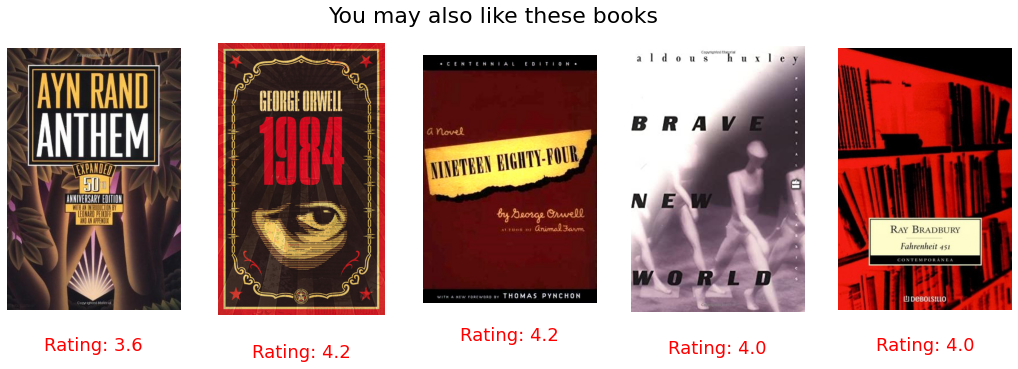

In [ ]:
content_based_recommender('animal farm')

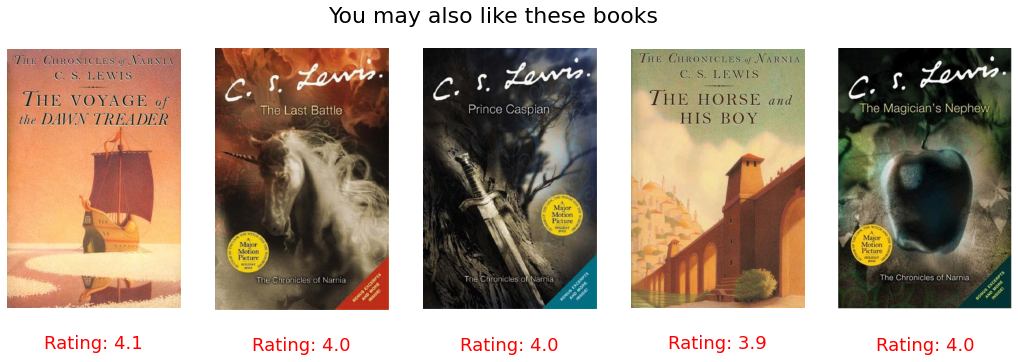

In [ ]:
content_based_recommender('the chronicles of narnia')

In [ ]:
data.keys()

Index(['url', 'bookTitle', 'bookImage', 'bookAuthors', 'bookDesc',
       'bookRating', 'ratingCount', 'reviewCount', 'bookPages', 'bookGenres',
       'bookISBN', 'recommendations'],
      dtype='object')